# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score,classification_report, recall_score, precision_score
# ROC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost as xgb

import torch 
from torch import nn, optim
from transformers import AutoTokenizer, AutoModelForPreTraining, AdamW, get_scheduler, get_linear_schedule_with_warmup
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import ElectraModel
import analysis_util

/home/pelle/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data

In [2]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/network_features/'
file_names=os.listdir(p)

data = []

for name in file_names:
    data.append(pd.read_csv(p+name))

df_gf=pd.concat(data)

df_balanced = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/balanced_data_chunked10.csv')

In [4]:
df_gf.drop_duplicates(inplace=True)
df=df_balanced.join(df_gf.set_index('id'),on='id')
df.dropna(subset='degree',inplace=True)
df=df[['author', 'date', 'score', 'n_comments', 'id',
       'n_awards', 'text_title', 'degree_cen',
       	'close_cen','activity',	'degree','N_nodes',
        'N_edges','mentions','frac_rec','N_rec','degree_in','degree_out','N_rec_author']]

df.loc[df.n_awards==0,'awarded']=0
df.loc[df.n_awards!=0,'awarded']=1

df['n_comments']=df.n_comments.apply(lambda x: np.sqrt(x**2))

df['date'] = pd.to_datetime(df['date'])

# def get_sentiment(text):
#     if type(text) == str:
#         com = sia.polarity_scores(text)['compound']
#         return com
#     else:
#         return np.nan

# def text_length(text):
#     if type(text) == str:
#         return len(text)
#     else:
#         return np.nan

# df['sentiment_compound']=df['text_title'].apply(lambda x: get_sentiment(x))
# df['text_length']=df['text_title'].apply(lambda x: text_length(x))

df=df.sample(frac=1)

In [5]:
subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird','DTU']
period = '2015-01-01-2022-01-01'

df_post_dict = {}
for subreddit in subreddits:
    print(subreddit)
    path_post='../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_posts.csv"
    path_awards = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards.csv"

    df_post=analysis_util.read_posts(path_post,path_awards)

    df_post['text_title']=df_post['title'] + ' ' + df_post['text']
    df_post['n_awards'].replace(np.nan,0,inplace=True)
    df_post['awarded']=df_post['n_awards'].apply(lambda x: 1 if x>0 else 0)
    df_post['sub']=subreddit
    df_post_dict[subreddit]=df_post

FourSentenceStories
Removed 0.008264462809917328 of the rows
Trump666
Removed 0.023008849557522026 of the rows
GraphTheory
Removed 0.046391752577319645 of the rows
jazznoir
Removed 0.056192660550458795 of the rows
indoorbouldering
Removed 0.013580246913580174 of the rows
kiwi_bird
Removed 0.01412429378531077 of the rows
DTU
Removed 0.02263374485596703 of the rows


In [6]:
df['sub'] = 'wallstreetbets'
df_post = pd.concat(df_post_dict.values())
df_all=pd.concat([df[['text_title', 'awarded', 'sub']],df_post[['text_title', 'awarded', 'sub']]])

# Analysis

In [7]:
class Dataset():
  def __init__(self, texts, targets, sub, tokenizer, max_len):
    self.text = texts
    self.targets = targets
    self.sub = sub
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    sub = self.sub[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long),
        'sub': sub}

In [8]:
class Electra(nn.Module):
    def __init__(self,num_labels=2):
        super(Electra, self).__init__()
        self.num_labels = num_labels

        # text features
        self.electra = ElectraModel.from_pretrained('google/electra-small-discriminator')
        self.dense_txt = nn.Linear(self.electra.config.hidden_size, self.electra.config.hidden_size) # 256

    def forward(self, input_ids=None,attention_mask=None):
        discriminator_hidden_states = self.electra(input_ids=input_ids,attention_mask=attention_mask)
        sequence_output = discriminator_hidden_states[0][:, 0, :] #[CLS] token
        sequence_output = self.dense_txt(sequence_output)

        return sequence_output

In [9]:
model = Electra()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ' + str(device))
model = model.to(device)
# please use torch.load with map_location=torch.device('cpu')

# map_location=torch.device('cpu')
path='/home/pelle/Master_Thesis/reports/model_3/best_model_state_electra.bin'
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')), strict=False)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device: cpu


_IncompatibleKeys(missing_keys=[], unexpected_keys=['dense_cat1.weight', 'dense_cat1.bias', 'dense_cat2.weight', 'dense_cat2.bias', 'dense_cat3.weight', 'dense_cat3.bias', 'dense_cat6.weight', 'dense_cat6.bias', 'dense_cat7.weight', 'dense_cat7.bias', 'dense_cat8.weight', 'dense_cat8.bias', 'out_proj.weight', 'out_proj.bias'])

In [10]:
tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator')

def create_dataloader(df, tokenizer, max_len, batch_size):

    ds = Dataset(
    texts=df["text_title"].to_numpy(),
    targets=df['awarded'].to_numpy(),
    sub=df['sub'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

    return DataLoader(ds,batch_size=batch_size,num_workers=2)

In [42]:
df_all_t = df_all.groupby('sub').apply(lambda x: x.sample(121)).reset_index(drop=True)
dl=create_dataloader(df_all_t, tokenizer, 200, 1)

emdeddings = []
y = []
subs = []
with torch.no_grad():
    i = 0
    for d in tqdm(dl):
        texts = d["text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        sub = d["sub"]

        outputs = model(
        input_ids=input_ids, 
        attention_mask=attention_mask)
        emdeddings.append(outputs.cpu().numpy()[0])
        y.append(targets.cpu().numpy())
        subs.append(sub)
        i += 1
        if i == 1000:
            break

  0%|          | 0/968 [00:00<?, ?it/s]/tmp/ipykernel_3772/2687847582.py:30: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'targets': torch.tensor(target, dtype=torch.long),
/tmp/ipykernel_3772/2687847582.py:30: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'targets': torch.tensor(target, dtype=torch.long),
100%|██████████| 968/968 [00:55<00:00, 17.44it/s]


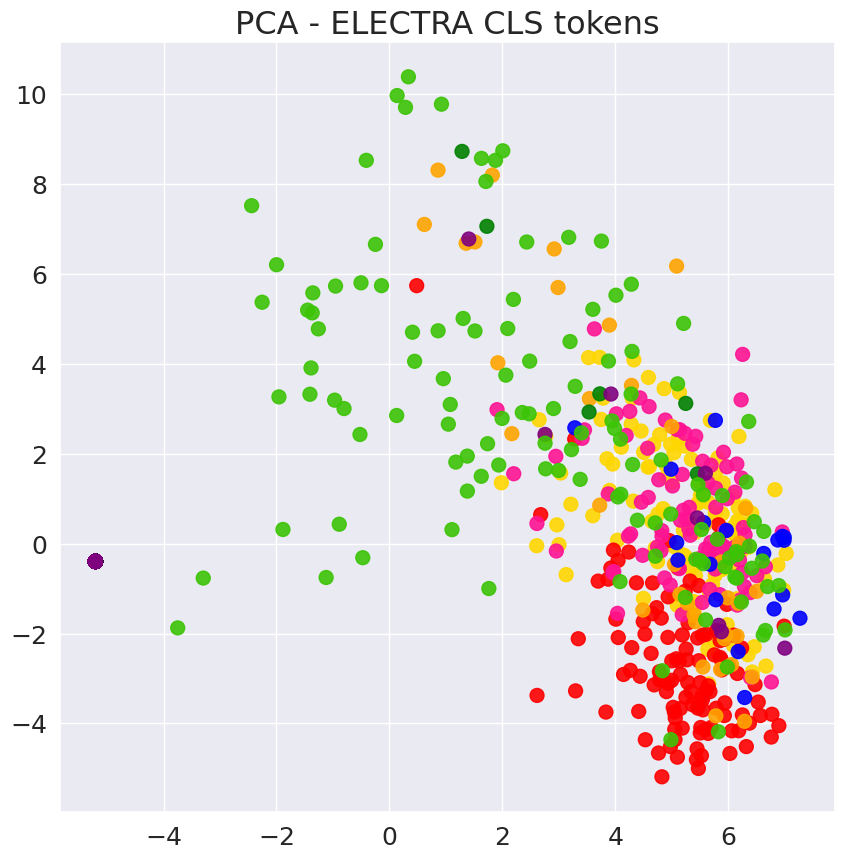

In [43]:
pca = PCA(n_components=2)
pca.fit(emdeddings)
pca_emdeddings = pca.transform(emdeddings)

# if sentis positive or negative or neutral
color_dict = {'FourSentenceStories':'#FF0000','Trump666':'#FFA500','GraphTheory':'#FF1493',
                'jazznoir':'#008000','indoorbouldering':'#0000FF','kiwi_bird':'#800080',
                'DTU':'#FFD700','wallstreetbets': '#3cc406'}

plt.figure(figsize=(10,10))
plt.scatter(pca_emdeddings[:,0],pca_emdeddings[:,1],c=[color_dict[subs[i][0]] for i in range(len(subs))],alpha=0.9, s=100)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('PCA - ELECTRA CLS tokens', fontsize=23)
plt.show()

# # variance explained
# pca = PCA()
# pca.fit(emdeddings)
# pca_emdeddings = pca.transform(emdeddings)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.show()

In [38]:
dl=create_dataloader(df, tokenizer, 200, 1)

emdeddings = []
y = []
subs = []
with torch.no_grad():
    i = 0
    for d in tqdm(dl):
        texts = d["text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        sub = d["sub"]

        outputs = model(
        input_ids=input_ids, 
        attention_mask=attention_mask)
        emdeddings.append(outputs.cpu().numpy()[0])
        y.append(targets.cpu().numpy())
        subs.append(sub)
        i += 1
        if i == 1000:
            break

  0%|          | 0/56278 [00:00<?, ?it/s]/tmp/ipykernel_3772/2687847582.py:30: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'targets': torch.tensor(target, dtype=torch.long),
/tmp/ipykernel_3772/2687847582.py:30: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'targets': torch.tensor(target, dtype=torch.long),
  2%|▏         | 999/56278 [00:51<47:39, 19.33it/s]  


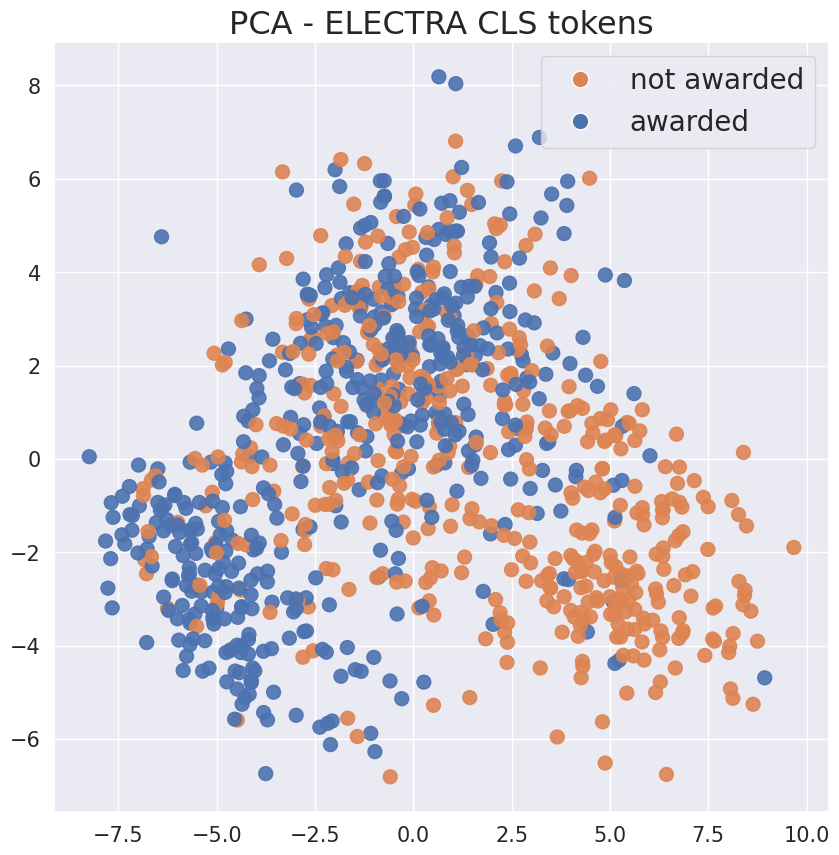

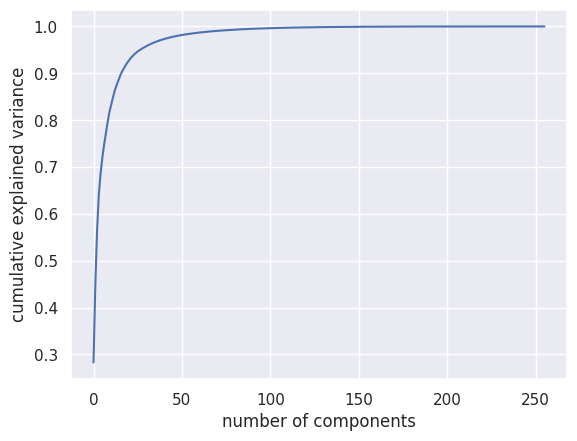

In [41]:
pca = PCA(n_components=2)
pca.fit(emdeddings)
pca_emdeddings = pca.transform(emdeddings)
color_map = {0:sns.color_palette()[1], 1:sns.color_palette()[0]}
plt.figure(figsize=(10,10))
plt.scatter(pca_emdeddings[:,0],pca_emdeddings[:,1],c=[color_map[y[i][0]] for i in range(len(y))],alpha=0.9, s=100)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
custom_scatter = [plt.Line2D([0], [0], marker='o', color='w', linewidth=0.1, label='not awarded',markerfacecolor=sns.color_palette()[1], markersize=12),
                    plt.Line2D([0], [0], marker='o', color='w', linewidth=0.1,label='awarded',markerfacecolor=sns.color_palette()[0], markersize=12)]
plt.legend(custom_scatter, ['not awarded', 'awarded'],fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('PCA - ELECTRA CLS tokens', fontsize=23)
plt.show()

# variance explained
pca = PCA()
pca.fit(emdeddings)
pca_emdeddings = pca.transform(emdeddings)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()